In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Running on GPU?
import setGPU

setGPU: Setting GPU to: 1


In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [4]:
# Set a random seed to reproduce the results

rng = np.random.RandomState(0)

In [5]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.titlesize"] = 18
matplotlib.rcParams["figure.titlesize"] = 18
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["legend.fontsize"] = 18

Define those yourself if you want to use your own data

In [6]:
#data_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"
#labels_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"

data_directory = "../data"
labels_directory = "../data"

# Drift Tubes Digi Occupancy Anomaly Problem

Reliable data quality monitoring is a key asset to deliver high-quality data for physics analysis for any modern large-scale High Energy Physics experiment. The current paradigm of the quality assessment in the Compact Muon Solenoid collaboration is based on the scrutiny of a large number of histograms by detector experts comparing them with a reference. This work investigates whether recent progress in deep learning techniques could contribute to the automation of this process, allowing the check of large volumes of data in real-time and improving the ability to detect unexpected failures.

## Load occupancy data to the dataframe

In [7]:
runs = [272011, 272012, 272014, 272017, 272021, 272774, 273158, 273730,
        274388, 274422, 274968, 274969, 275310, 275311, 275847, 275890,
        276244, 276283, 276384, 276582, 276587, 276775, 276776, 276950,
        278509, 278820, 278822, 279694, 279766, 279794, 280018, 281693,
        281727, 281976, 282735, 282814, 284041, 284042, 284043, 284044,
        297411, 297467, 297468, 297469, 297484, 297665, 297666, 297678,
        299000, 300087, 300390, 300391, 300392, 300393, 300395, 300396,
        300397, 300398, 300399, 300497, 300558, 301142, 301383, 301384,
        302031, 302038, 302040, 302041, 302042, 302043, 302350, 302548,
        302634, 302635, 304144, 304737, 304738, 304739, 304740, 305064,
        305081, 306041, 306042, 306049]

drift_tubes_layers = pd.DataFrame()
for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);
print("Done. Collected %s layers" % drift_tubes_layers.shape[0], end="\r")

In [8]:
# Convert string data to list

drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

In [9]:
# Append score from labels data file

labels_frame = pd.read_csv(("%s/labels.csv" % labels_directory),
                           names=["wheel", "station", "sector", "run", "layer", "score"])

def apply_score(layer):
    """Applies scores form label file"""
    score = labels_frame[(labels_frame.wheel == layer.wheel) &
                         (labels_frame.station == layer.station) &
                         (labels_frame.sector == layer.sector) &
                         (labels_frame.run == layer.run) &
                         (labels_frame.layer == layer.layer)].score.values
    if not len(score):
        return np.nan

    return score[0]

drift_tubes_layers["score"] = drift_tubes_layers.apply(apply_score, axis=1);

## Preprocessing

Use median polling to remove extreme values (remove noise):

In [10]:
SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

Use bilinear interpolation to resize all the data samples to match the smallest:

In [11]:
print("Minimum raw length: % s" % min(drift_tubes_layers["content"].apply(len)))
print("Maximum raw length: % s" % max(drift_tubes_layers["content"].apply(len)))
print("Minimum smoothed length: % s" % min(drift_tubes_layers["content_smoothed"].apply(len)))
print("Maximum smoothed length: % s" % max(drift_tubes_layers["content_smoothed"].apply(len)))

Minimum raw length: 47
Maximum raw length: 96
Minimum smoothed length: 45
Maximum smoothed length: 94


In [12]:
def resize_occupancy(layer):
    """Resizes layer data to <SAMPLE_SIZE> using bilinear interpolation"""
    # At this point skimage.transform.resize has some problems, please use scipy < 1.2.0
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp="bilinear", mode="F")

SAMPLE_SIZE = min(drift_tubes_layers["content"].apply(len))
drift_tubes_layers["content_resized"] = drift_tubes_layers["content"].apply(resize_occupancy)

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_layers["content_smoothed_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

Scale input to account for integration time and beam intensity:

In [13]:
def scale_occupancy(layer):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

drift_tubes_layers["content_scaled"] = drift_tubes_layers["content_resized"].apply(scale_occupancy)
drift_tubes_layers["content_smoothed_scaled"] = drift_tubes_layers["content_smoothed_resized"].apply(scale_occupancy)

### Visualize preprocessing steps

Combine per layer data to per chamber data (this is used only for the visualization section):

In [14]:
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):
                if labels_frame[(labels_frame.run == run) &
                                (labels_frame.wheel == wheel) &
                                (labels_frame.station == station) &
                                (labels_frame.sector == sector)].empty:
                    continue

                chamber = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                             (drift_tubes_layers.wheel == wheel) &
                                             (drift_tubes_layers.station == station) &
                                             (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                                                ascending=1)
    
                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, 47)
                occupancy_scaled = np.concatenate(
                    chamber["content_scaled"].values).reshape(-1, 47)
                occupancy_smoothed_resized = np.concatenate(
                    chamber["content_smoothed_resized"].values).reshape(-1, 45)
                occupancy_smoothed_scaled = np.concatenate(
                    chamber["content_smoothed_scaled"].values).reshape(-1, 45)

                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                
                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer

                score = sum(chamber.score.values)
                
                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_raw": np.concatenate(
                            occupancy_raw).reshape(len(chamber), extended_size_raw),
                        "content_smoothed": np.concatenate(
                            occupancy_smoothed).reshape(len(chamber), extended_size_smoothed),
                        "content_resized": occupancy_resized,
                        "content_smoothed_resized": occupancy_smoothed_resized,
                        "content_scaled": occupancy_scaled,
                        "content_smoothed_scaled": occupancy_smoothed_scaled}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data),
                                                                   ignore_index=True)

In [15]:
def plot_occupancy_hitmap(data, title):
    """Draws occuypancy plot"""
    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1","5","9"])
    ax.set_yticks([0, 4, 8])
    
    plt.xlabel("Channel")
    plt.ylabel("Layer")
    
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title, x=-13)
    plt.show();
    
def get_title(title, show):
    """Returns a title for a plot"""
    return ("%s Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show, smoothed):
    """Visualizes preprocessing steps"""
    if smoothed:
        plot_occupancy_hitmap(show.content_smoothed, get_title("Smoothed", show))
        plot_occupancy_hitmap(show.content_smoothed_resized, get_title("Reshaped", show))
        plot_occupancy_hitmap(show.content_smoothed_scaled, get_title("Scaled", show)) 

    else:
        plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))
        plot_occupancy_hitmap(show.content_resized, get_title("Reshaped", show))
        plot_occupancy_hitmap(show.content_scaled, get_title("Scaled", show))

Example of preprocessing pipeline for <b>chamber without problems</b>:

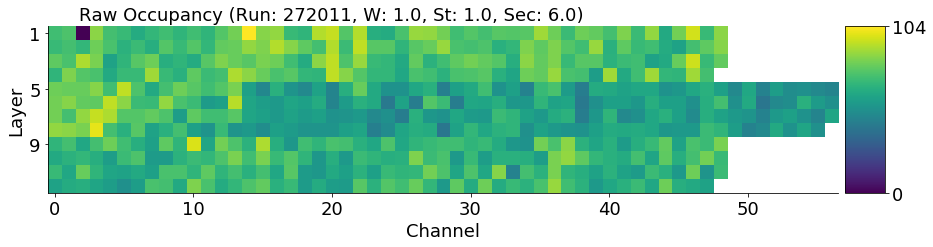

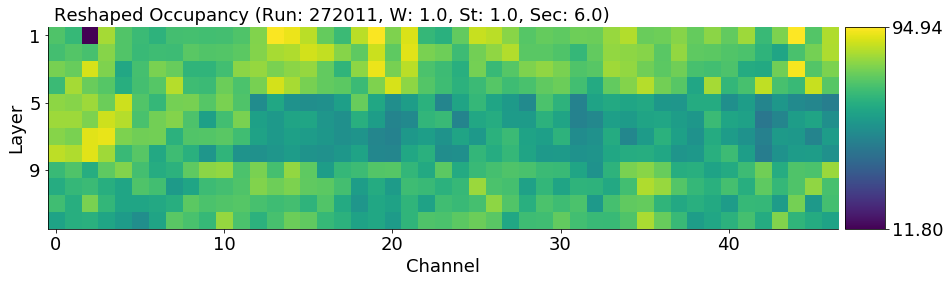

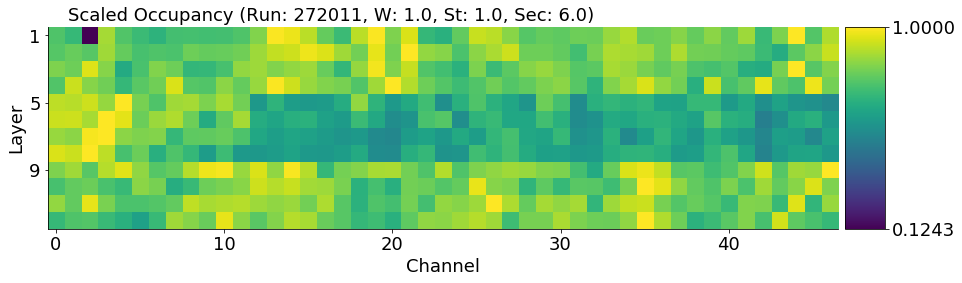

In [16]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], False)

Example of preprocessing pipeline for <b>chamber with one faulty layer</b>:

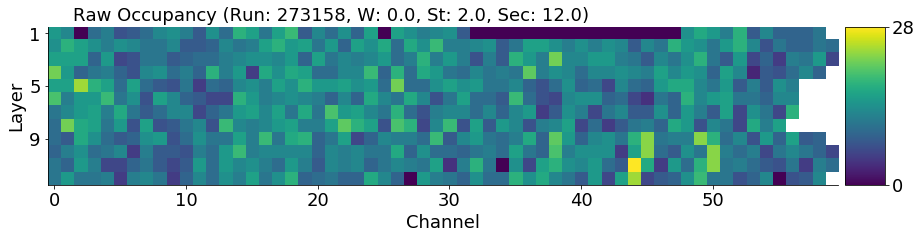

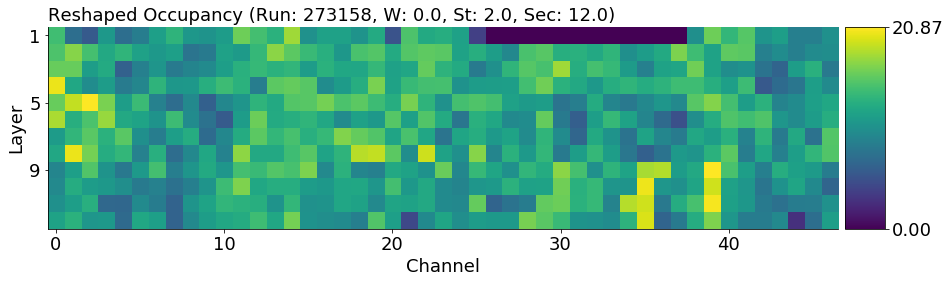

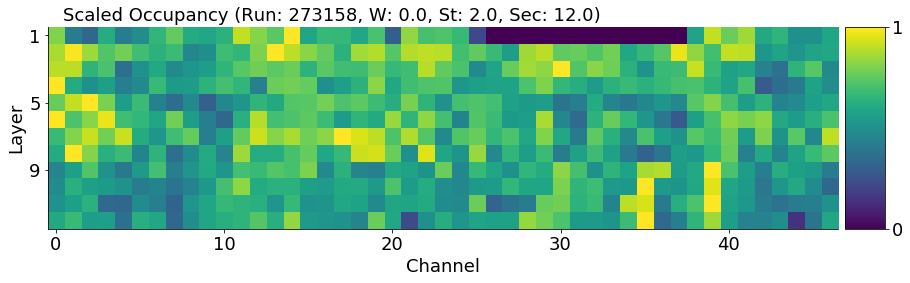

In [17]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 11].iloc[0], False)

Example of preprocessing pipeline for <b>chamber with twelve faulty layer</b>:

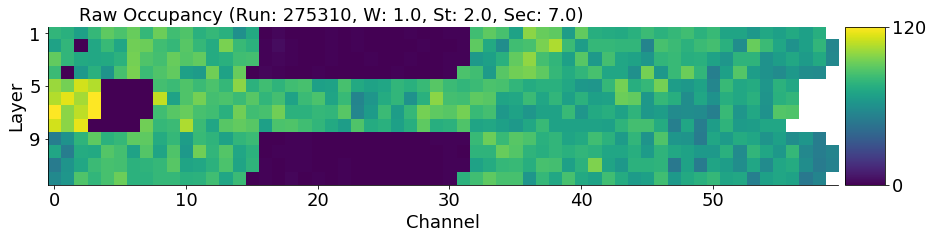

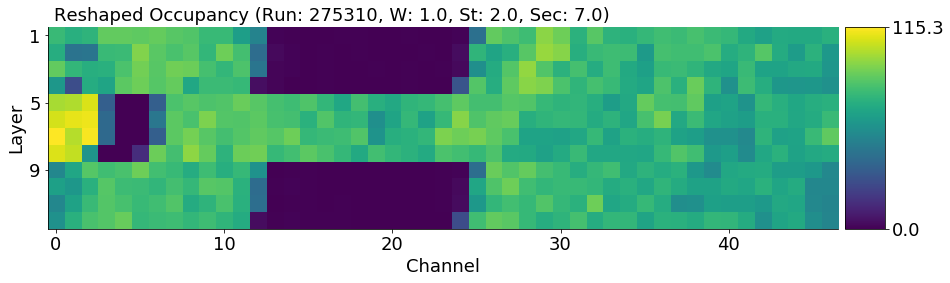

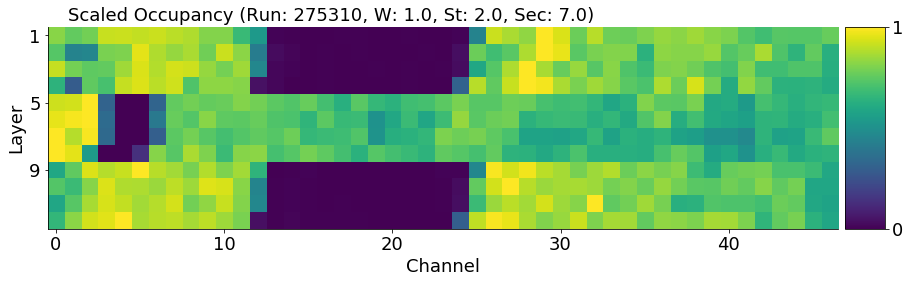

In [18]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[3], False)

Example of <b>alternative</b> preprocessing (with median polling) pipeline for <b>chamber without problems</b>:

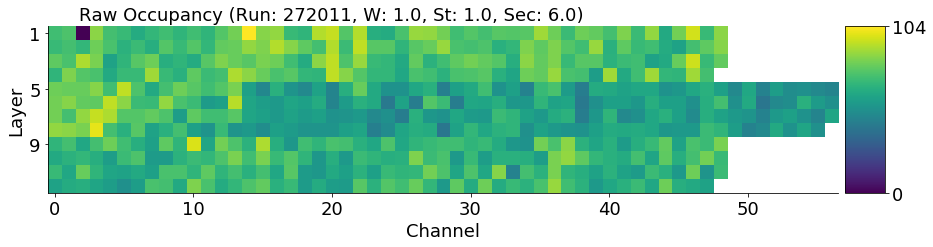

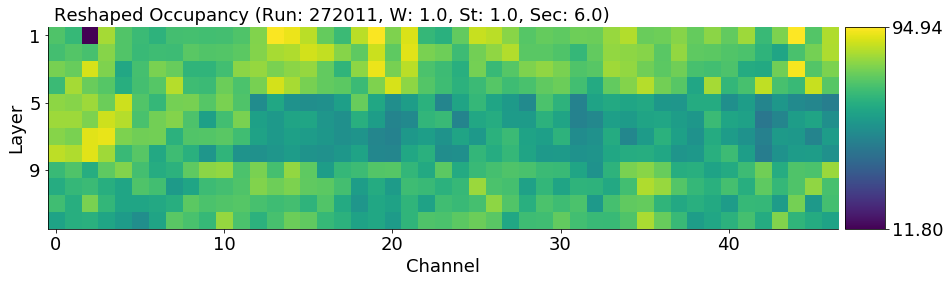

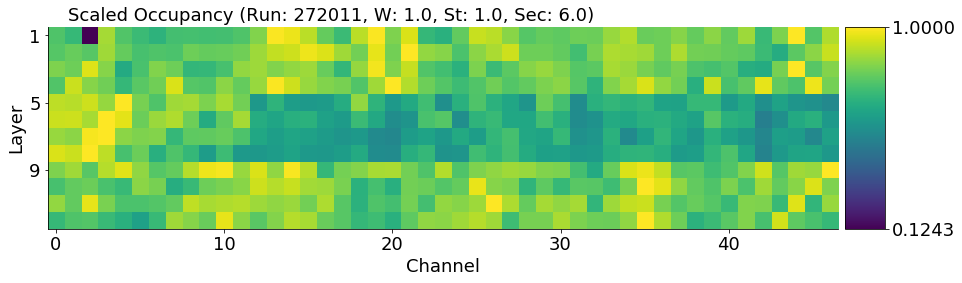

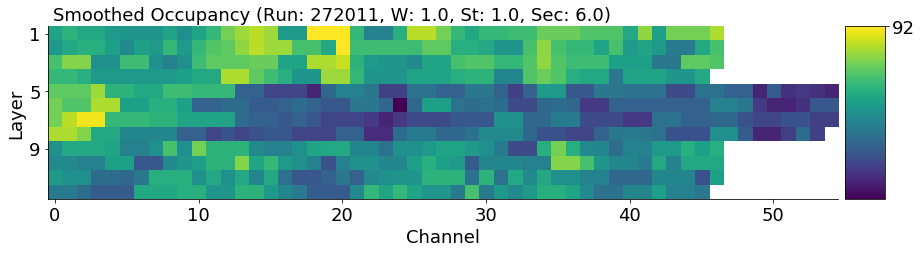

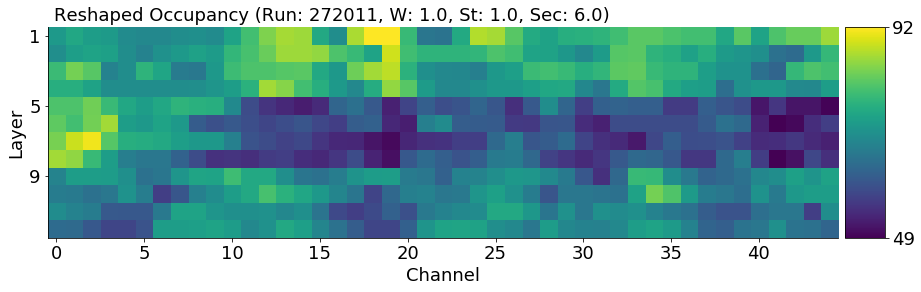

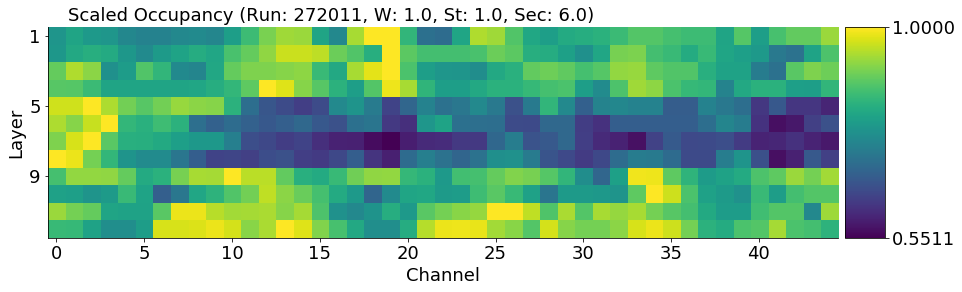

In [19]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], False)
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], True)

## Baseline

### Current production tests

In [20]:
def threshold_test(content):
    """Calculate score that mirrors test in production"""
    return (float(len(np.where(content == 0)[0])) / len(np.where(~np.isnan(content))[0]))

drift_tubes_chambers["treshold"] = drift_tubes_chambers["content_raw"].apply(threshold_test)

Performace of the current tests w.r.t. number of faulty layers:

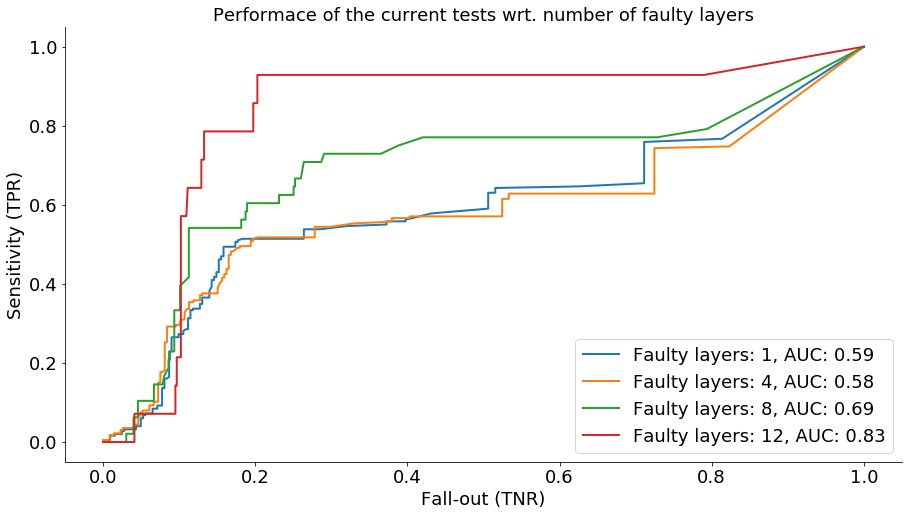

In [21]:
fig, ax = plt.subplots()

for x, faulty_layers in enumerate([1,4,8,12]):
    score = 2*(drift_tubes_chambers["score"] <= (12 - faulty_layers)) - 1
    false_positive_rate, true_positive_rate, _ = roc_curve(score, drift_tubes_chambers["treshold"])

    plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
             label=("Faulty layers: %s, AUC: %s" % (
                 faulty_layers, round(auc(false_positive_rate, true_positive_rate), 2))))

plt.title("Performace of the current tests wrt. number of faulty layers")           
plt.legend()
plt.ylabel("Sensitivity (TPR)")
plt.xlabel("Fall-out (TNR)")
plt.show();

### Split the dataset to be able to use supervised learning:

In [22]:
def change_score(score):
    return -(2*score-1)

drift_tubes_layers['score'] = drift_tubes_layers['score'].apply(change_score)

drift_tubes_layers_scored = drift_tubes_layers[~np.isnan(drift_tubes_layers.score)]

anomalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == 1]
normalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

612 faults and 5668 good samples. In total: 6280.
Number of anomalies in the train set: 123
Number of normal in the train set: 1134


### Baseline simple alternative tests

In [23]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=("%s, AUC: %s" % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 "o",
                 label="CNN working point")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend()
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.show();

In [24]:
def sobel(content):
    return max(abs(ndimage.sobel(content)[0]))

def variance(content):
    return np.var(content)
    
layers_test["sobel_score"] = layers_test["content_smoothed_scaled"].apply(sobel)
layers_test["variance_score"] = layers_test["content_smoothed_scaled"].apply(variance)

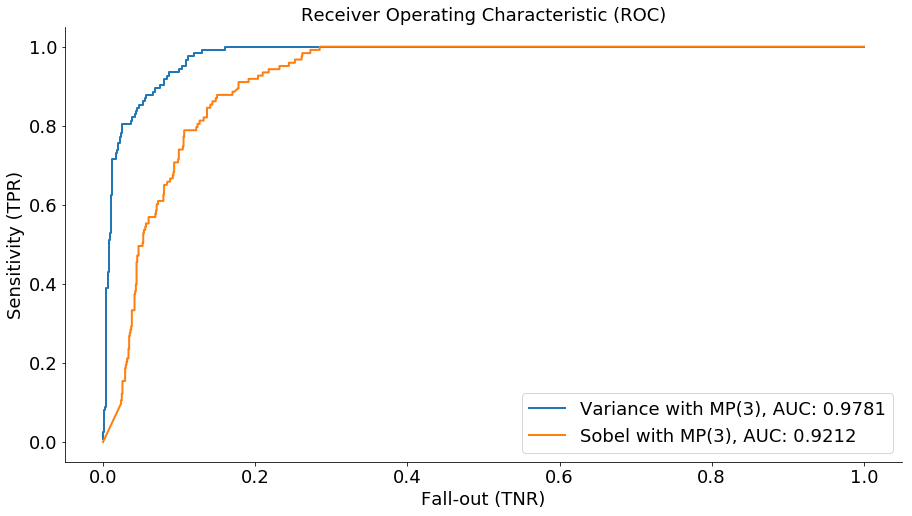

In [25]:
get_roc_curve(layers_test,[('Variance with MP(3)', 'variance_score'),
                           ('Sobel with MP(3)', 'sobel_score')])

### Benchmarking SVM and IF:

Cross validate model selection using Stratified5Fold and GridSearchCV:

In [26]:
def cross_validation_spit(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [27]:
# This may take some time...
param_grid = [{'nu': np.array(range(1, 10, 1))/10.0,
               'gamma': ['auto', 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['linear', 'rbf']}]

svmclf = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                               -layers_train["score"],
                               svm.OneClassSVM(random_state=rng),
                               param_grid)

In [28]:
# This may take some time...
param_grid = [{'max_samples': [100, 1000],
               'n_estimators': [10, 100],
               'contamination': np.array(range(6, 13, 1))/100.0}]

ifparams = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                                 -layers_train["score"],
                                 IsolationForest(random_state=rng),
                                 param_grid)

In [29]:
# Retrain IF using all unlabelled samples
ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)
ifclf.fit(np.concatenate(drift_tubes_layers[np.isnan(drift_tubes_layers.score)]["content_smoothed_scaled"].values));

In [30]:
layers_test['svm_score'] = -svmclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))
layers_test['if_score'] = -ifclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))

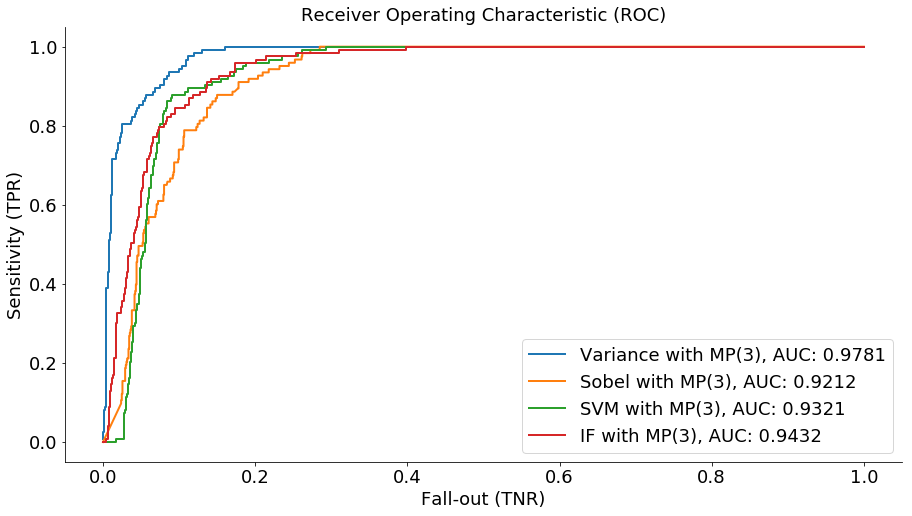

In [31]:
get_roc_curve(layers_test,[('Variance with MP(3)', 'variance_score'),
                           ('Sobel with MP(3)', 'sobel_score'),
                           ('SVM with MP(3)', 'svm_score'),
                           ('IF with MP(3)', 'if_score')])

### Train and test Neural Networks:

Start Keras session:

In [32]:
sess = tf.Session()
K.set_session(sess)

Generate CNN input:

In [33]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 47))

def cae_generate_input():
    return np.array(np.concatenate(
        drift_tubes_layers[np.isnan(drift_tubes_layers.score)].content_scaled.values)).reshape(-1, 47)

(train_x, train_y, val_x, val_y, test_x) = generate_input()
train_cae = cae_generate_input()

Due to imbalanced classes model requires different penalization of the misclassification. Calculate weights for different classes:

In [34]:
classes_count = sum(train_y)
classes_count = classes_count/sum(classes_count)
class_weight = {0: classes_count[1], 1: classes_count[0]}
print(class_weight)

{0: 0.097312095569935295, 1: 0.90268790443006475}


Define networks:

In [35]:
def artificial_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def convolutional_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name='input_cnn'))
    model.add(Conv1D(10, 3, strides=1, padding='valid', activation='relu', name="convolution"))
    model.add(MaxPooling1D(pool_size=5, strides=5, padding='valid', name="polling"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(8, activation='relu', name="dense"))
    model.add(Dense(2, activation='softmax', name='output'))
    return model

def convolutional_autoencoder():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name='input_cae'))
    model.add(Conv1D(8, 3, strides=1, padding='valid', activation='relu', name="convolution1"))
    model.add(AveragePooling1D(pool_size=5, strides=5, padding='valid', name="polling1"))
    model.add(Conv1D(8, 3, strides=3, padding='valid', activation='relu', name="convolution2"))
    model.add(AveragePooling1D(pool_size=3, strides=1, padding='valid', name="polling2"))    
    
    model.add(UpSampling1D(10, name="upsampling1"))
    model.add(Conv1D(8, 4, strides=1, padding='same', activation='relu', name="convolution3"))
    model.add(UpSampling1D(5, name="upsampling2"))
    model.add(Conv1D(1, 4, strides=1, padding='valid', activation='relu', name="convolution4"))
    model.add(Reshape((47,), input_shape=(47,1), name='output_cae'))
    return model

ann = artificial_neural_network()
cnn = convolutional_neural_network()
cae = convolutional_autoencoder()
print("Neural Network Architecture:")
ann.summary()
print("Convolutional Network Architecture:")
cnn.summary()
print("Convolutional Autoencoder Architecture:")
cae.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 47, 1)             0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 47)                0         
_________________________________________________________________
dense_ann (Dense)            (None, 16)                768       
_________________________________________________________________
output_ann (Dense)           (None, 2)                 34        
Total params: 802
Trainable params: 802
Non-trainable params: 0
_________________________________________________________________
Convolutional Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_cnn (Reshape)          (None, 47, 1)             0         
_____________

Train neural networks:

In [47]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer="adam")

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("../model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)

history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=class_weight)

history_cnn = train_nn(cnn,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "cnn",
                       validation_data=(val_x, val_y),
                       class_weight=class_weight)

Epoch 01796: early stopping


Plot loss vs. epoch:

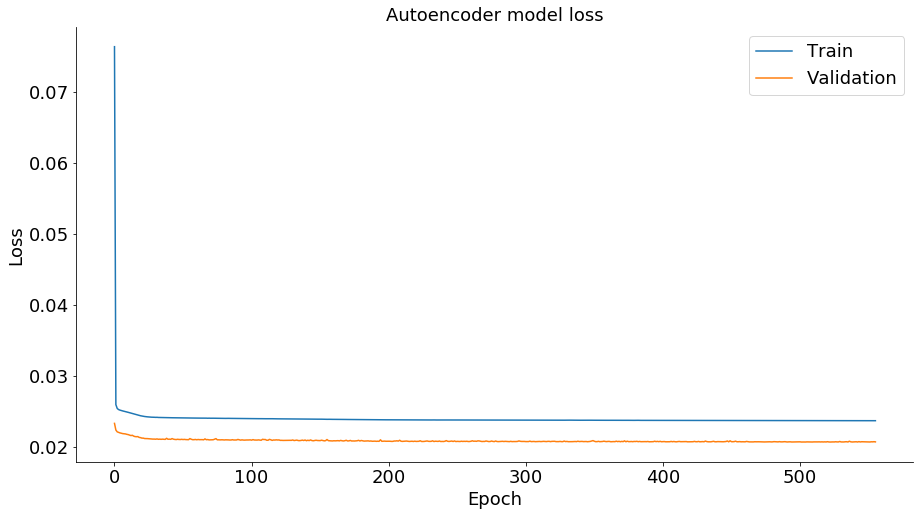

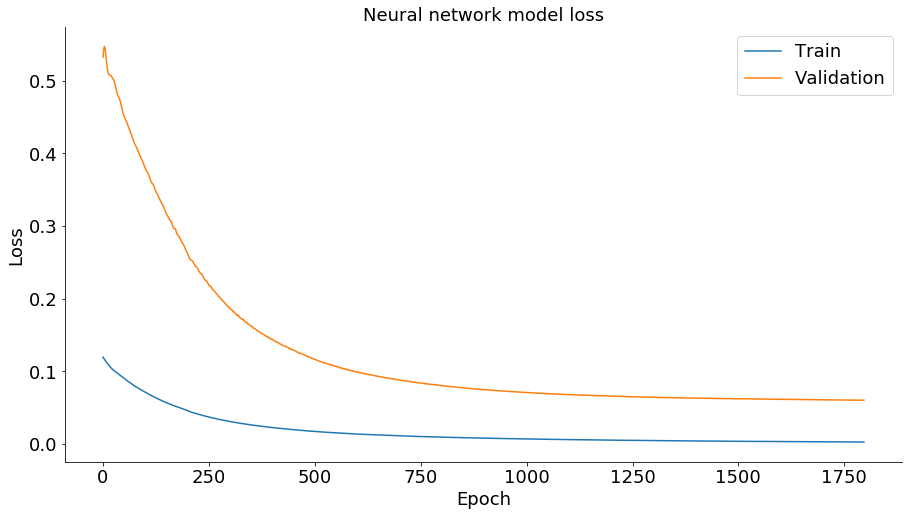

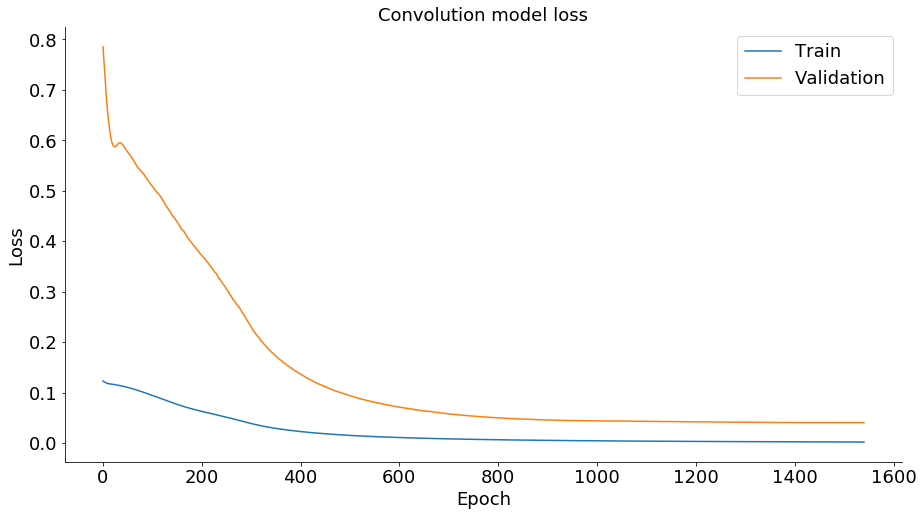

In [48]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"])
    plt.show();
    
plot_training_loss(history_cae.history, "Autoencoder model loss")
plot_training_loss(history_ann.history, "Neural network model loss")
plot_training_loss(history_cnn.history, "Convolution model loss")

Reload models from saved:

In [49]:
ann_model = load_model("../model_keras/ann.h5")
cae_model = load_model("../model_keras/cae.h5")
cnn_model = load_model("../model_keras/cnn.h5")

Export models as .pb:

In [50]:
# Needed for CMSSW implementation/Stability tests:
# print(cnn_model.inputs)
# print(cnn_model.output)
# builder = tf.saved_model.builder.SavedModelBuilder("../model")
# builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
# builder.save()

Calculate score for trained networks:

In [51]:
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]
layers_test["cnn_score"] = cnn_model.predict(np.array(test_x))[:, 1]

This is how the ROC curve for the model looks like:

In [52]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
specificity_cnn, sensitivity_cnn = benchmark(layers_test["score"], layers_test["cnn_score"], 0.5)

Model accuracy: 0.9905
Model sensitivity: 0.9593
Model specificity: 0.9938


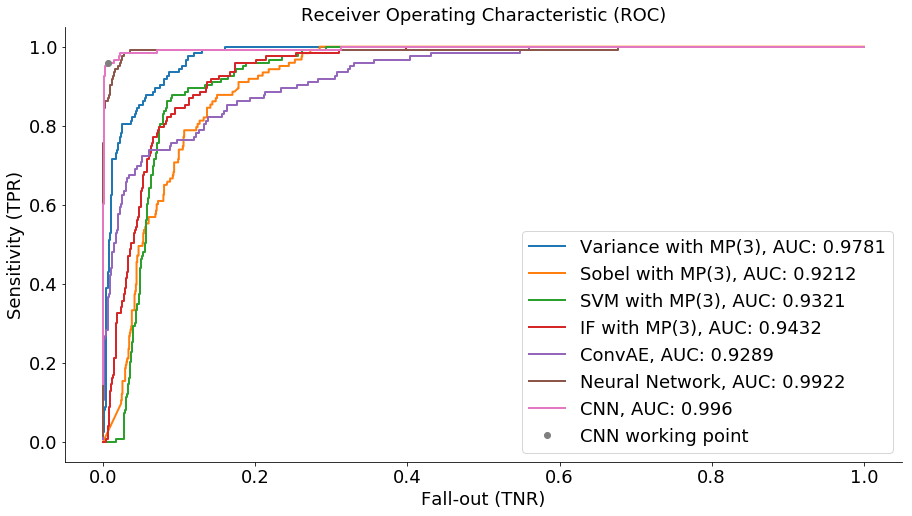

In [53]:
get_roc_curve(layers_test,
              [("Variance with MP(3)", "variance_score"),
               ("Sobel with MP(3)", "sobel_score"),
               ("SVM with MP(3)", "svm_score"),
               ("IF with MP(3)", "if_score"),
               ("ConvAE", "cae_score"),
               ("Neural Network", "ann_score"),
               ("CNN", "cnn_score")],
              (specificity_cnn, sensitivity_cnn))

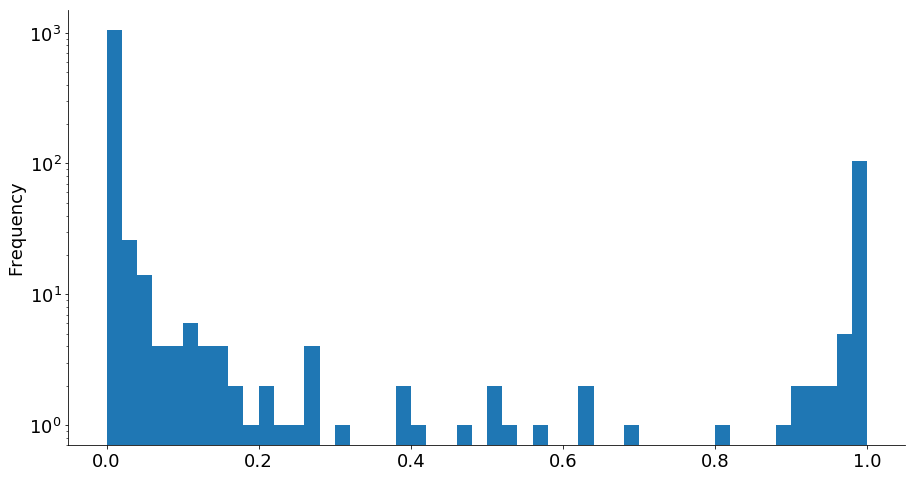

In [54]:
# Distribution of scores:
layers_test["cnn_score"].plot.hist(bins=50, logy=True);